<a href="https://colab.research.google.com/github/DanyaFire/StatPrac/blob/main/Profect_ts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Подключаем библиотеки

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

Подготовка данных

In [3]:
financial_data = pd.read_excel("HW_Project.xlsx").sort_values("Date")
financial_data.set_index("Date", inplace=True)
financial_data['Balance'] = financial_data['Income'] - financial_data['Outcome']

Визуализуируем

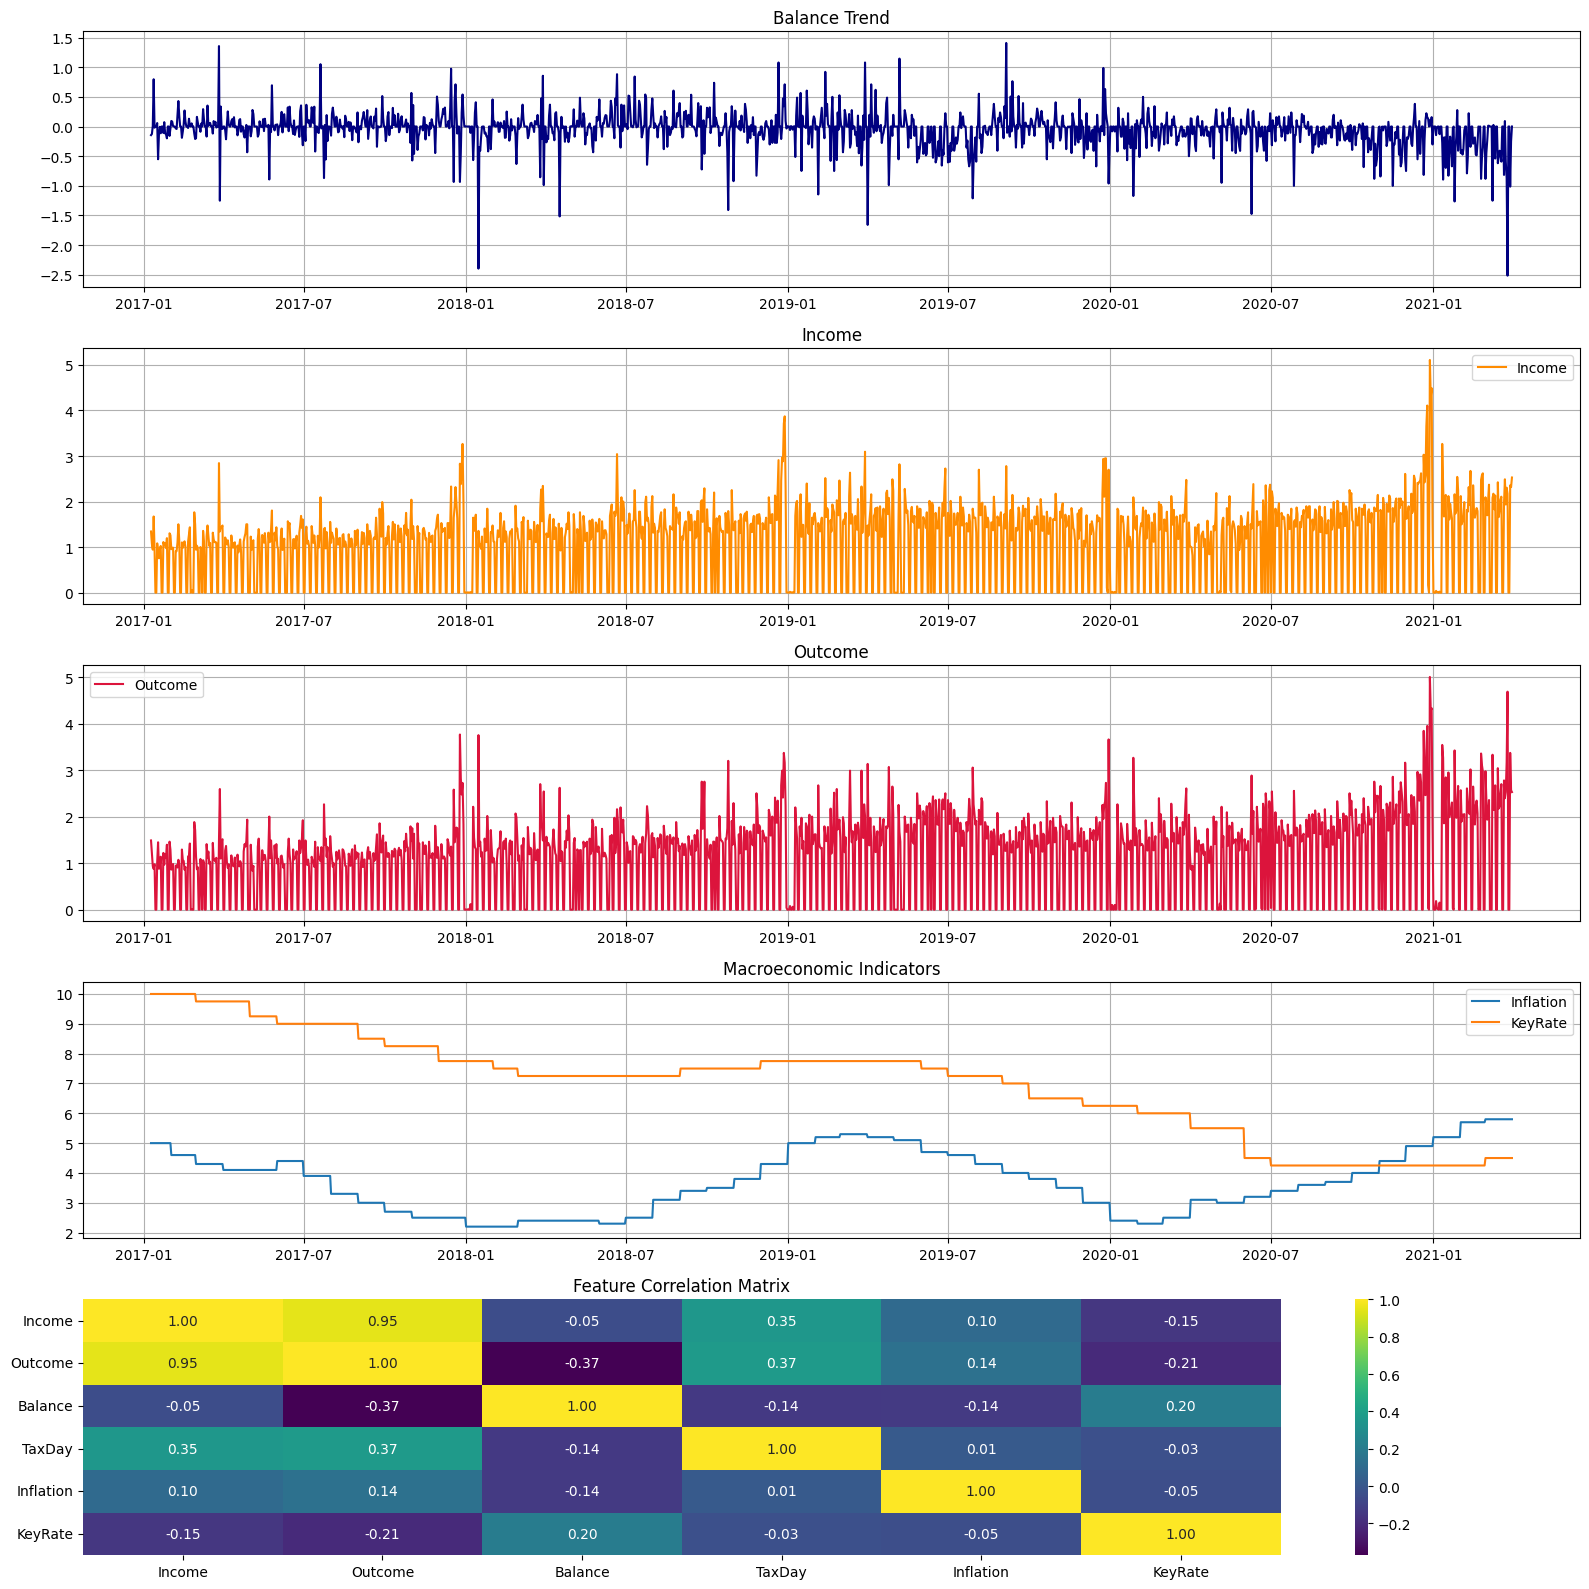

In [4]:
def plot_financial_metrics(data):
    fig, axes = plt.subplots(5, 1, figsize=(16, 16))

    axes[0].plot(data.index, data['Balance'], color='navy')
    axes[0].set_title("Balance Trend", fontsize=12)
    axes[0].grid(True)

    axes[1].plot(data.index, data['Income'], color='darkorange', label='Income')
    axes[1].set_title("Income", fontsize=12)
    axes[1].legend()
    axes[1].grid(True)

    axes[2].plot(data.index, data['Outcome'], color='crimson', label='Outcome')
    axes[2].set_title("Outcome", fontsize=12)
    axes[2].legend()
    axes[2].grid(True)

    axes[3].plot(data.index, data['Inflation'], label='Inflation')
    axes[3].plot(data.index, data['KeyRate'], label='KeyRate')
    axes[3].set_title("Macroeconomic Indicators", fontsize=12)
    axes[3].legend()
    axes[3].grid(True)

    sns.heatmap(data[['Income', 'Outcome', 'Balance', 'TaxDay', 'Inflation', 'KeyRate']].corr(),
                annot=True, fmt=".2f", cmap='viridis', ax=axes[4])
    axes[4].set_title("Feature Correlation Matrix", fontsize=12)

    plt.tight_layout()
    plt.show()

plot_financial_metrics(financial_data)


Анализ временных рядов

Использованные метрик: MAE, RMSE, $R^2$

Построение линейной модели ARIMA

In [5]:
balance_series = financial_data['Balance'].dropna()
train_size = int(len(balance_series) * 0.8)
train_data, test_data = balance_series[:train_size], balance_series[train_size:]

arima_model = ARIMA(train_data, order=(1,0,1))
arima_results = arima_model.fit()
forecast_values = arima_results.get_forecast(steps=len(test_data)).predicted_mean

def evaluate_model(true_values, predictions, model_name):
    metrics = {
        'MAE': mean_absolute_error(true_values, predictions),
        'RMSE': np.sqrt(mean_squared_error(true_values, predictions)),
        'R²': r2_score(true_values, predictions)
    }
    print(f"\n{model_name} Performance:")
    for name, value in metrics.items():
        print(f"{name}: {value:.3f}")
    return metrics

evaluate_model(test_data, forecast_values, "ARIMA(1,0,1)")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



ARIMA(1,0,1) Performance:
MAE: 0.206
RMSE: 0.343
R²: -0.232


{'MAE': 0.20564306462625415,
 'RMSE': np.float64(0.34347269547253145),
 'R²': -0.23177296821559912}

Построение результатов

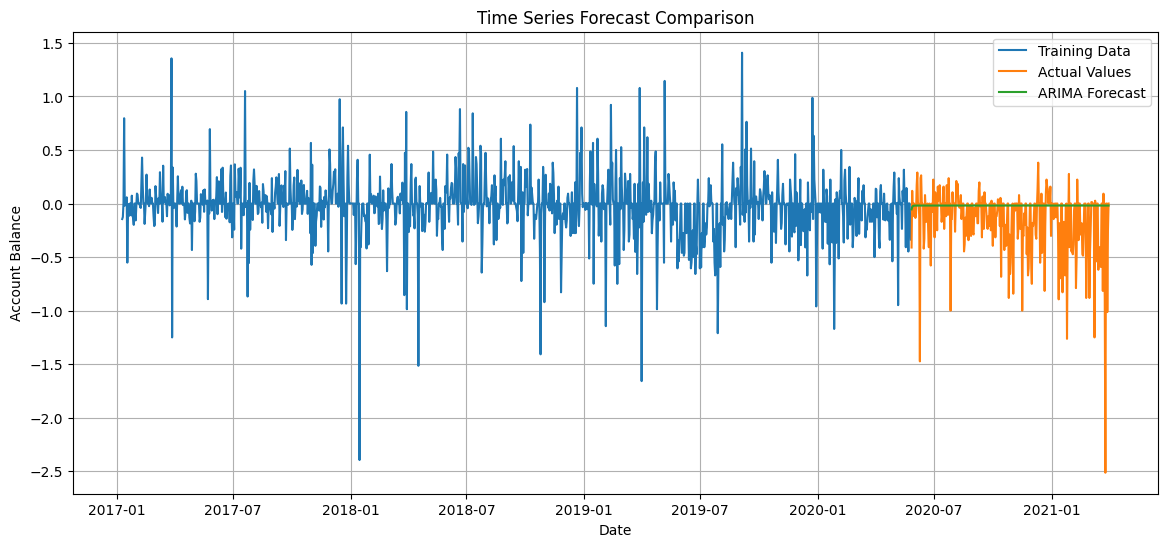

In [6]:
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Actual Values')
plt.plot(test_data.index, forecast_values, label='ARIMA Forecast')
plt.title("Time Series Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Account Balance")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# TSFresh with rolling windows
window_size = 30
horizon = 10
rows, targets, macro_features = [], [], []

for start in range(len(financial_data) - window_size - horizon):
    end = start + window_size
    target_time = end + horizon
    if pd.isna(financial_data['Balance'].iloc[target_time]):
        continue

    window = financial_data.iloc[start:end].copy()
    window["id"] = start
    window["timestamp"] = window.index
    window["balance_value"] = window["Balance"]

    rows.append(window[["id", "timestamp", "balance_value"]])
    targets.append(financial_data["Balance"].iloc[target_time])

    # Macroeconomic features
    macro = window[['Inflation', 'KeyRate', 'TaxDay']].mean().values
    macro_features.append(macro)

tsfresh_df = pd.concat(rows)
target_series = pd.Series(targets).reset_index(drop=True)
macro_df = pd.DataFrame(macro_features, columns=["Inflation", "KeyRate", "TaxDay"])

extracted_features = extract_features(
    tsfresh_df,
    column_id="id",
    column_sort="timestamp",
    default_fc_parameters=ComprehensiveFCParameters(),
    n_jobs=0
)
impute(extracted_features)
selected_features = select_features(extracted_features, target_series)


Feature Extraction: 100%|██████████| 1503/1503 [02:39<00:00,  9.44it/s]
/usr/local/lib/python3.11/dist-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['balance_value__fft_coefficient__attr_"real"__coeff_16'
 'balance_value__fft_coefficient__attr_"real"__coeff_17'
 'balance_value__fft_coefficient__attr_"real"__coeff_18'
 'balance_value__fft_coefficient__attr_"real"__coeff_19'
 'balance_value__fft_coefficient__attr_"real"__coeff_20'
 'balance_value__fft_coefficient__attr_"real"__coeff_21'
 'balance_value__fft_coefficient__attr_"real"__coeff_22'
 'balance_value__fft_coefficient__attr_"real"__coeff_23'
 'balance_value__fft_coefficient__attr_"real"__coeff_24'
 'balance_value__fft_coefficient__attr_"real"__coeff_25'
 'balance_value__fft_coefficient__attr_"real"__coeff_26'
 'balance_value__fft_coefficient__attr_"real"__coeff_27'
 'balance_value__fft_coefficient__attr_"real"__coeff_28'
 'balance_value__fft_coefficient__attr_"real"__coeff_29'
 'balance_value_

Работа с матрицей признаков и таргетом

In [8]:
# Feature Integration
feature_matrix = pd.concat([selected_features.reset_index(drop=True), macro_df.reset_index(drop=True)], axis=1)
target_vector = target_series

# Model Pipeline
model_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('feature_selector', SelectKBest(f_regression, k=min(12, feature_matrix.shape[1]))),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_space = {
    'regressor__n_estimators': [500, 750],
    'regressor__max_depth': [3, 5],
    'regressor__learning_rate': [0.05, 0.1]
}

Прогноз и вывод важных факторов

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=500; total time=   0.3s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=500; total time=   0.3s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=500; total time=   0.3s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=500; total time=   0.2s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=500; total time=   0.3s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=750; total time=   1.0s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=750; total time=   2.9s
[CV] END regressor__learning_rate=0.05, regressor__max_depth=3, regressor__n_estimators=750; total time=   0.5s
[CV] END regressor__learning_rate=0.05, regr

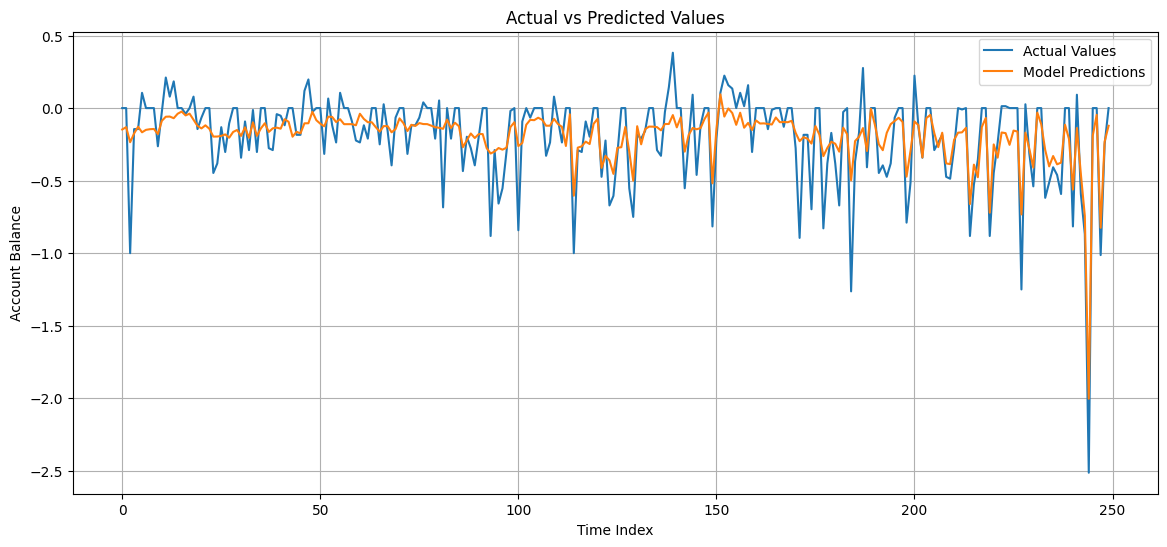


Optimized XGBoost Performance:
MAE: 0.145
RMSE: 0.192
R²: 0.631

Best Parameters: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 500}


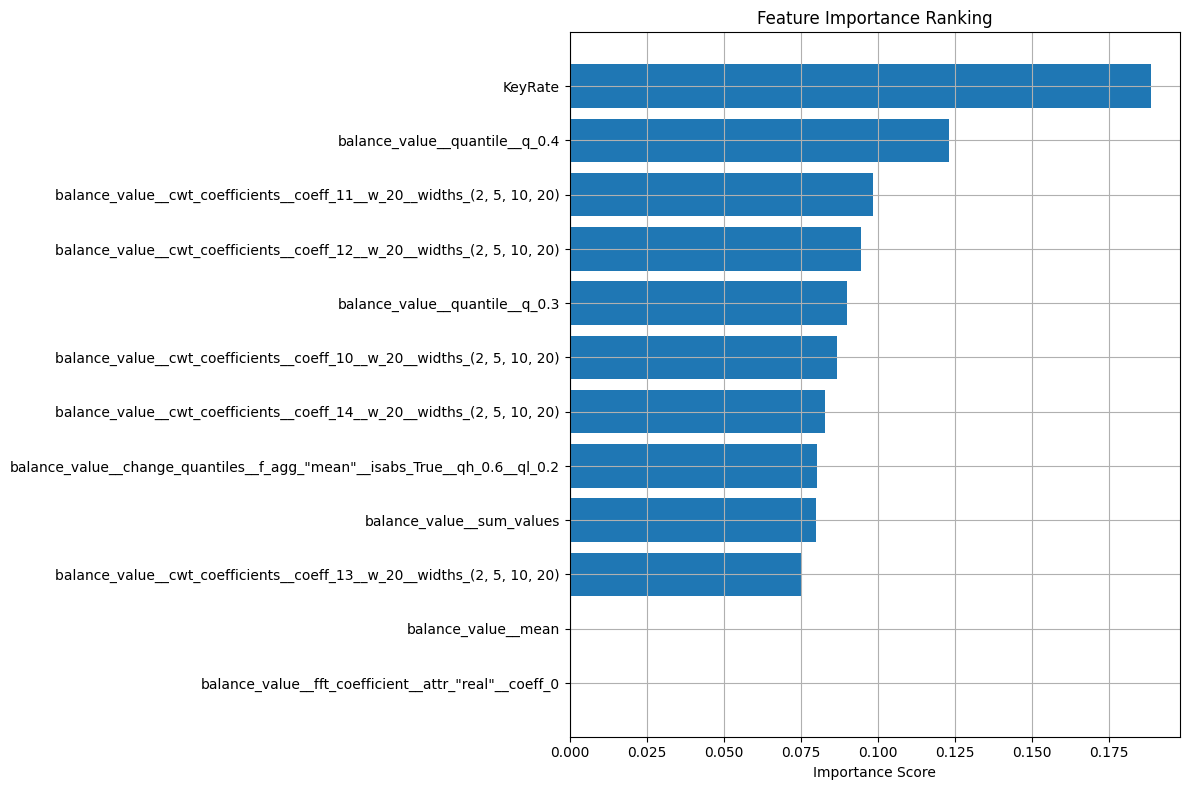

In [9]:

# Adaptive TimeSeriesSplit based on sample size
n_samples = len(feature_matrix)
max_splits = min(5, n_samples - 1)

if max_splits < 2:
    raise ValueError(f"Недостаточно данных ({n_samples} образцов) для кросс-валидации. Нужно минимум 3. Увеличьте количество данных или уменьшите размер окна.")

ts_cv = TimeSeriesSplit(n_splits=max_splits)
grid_search = GridSearchCV(model_pipeline, param_space, cv=ts_cv, scoring='r2', verbose=2)
grid_search.fit(feature_matrix, target_vector)

# Evaluation
best_model = grid_search.best_estimator_
_, test_indices = list(ts_cv.split(feature_matrix))[-1]
X_test = feature_matrix.iloc[test_indices]
y_test = target_vector.iloc[test_indices]
y_pred = best_model.predict(X_test)

plt.figure(figsize=(14, 6))
plt.plot(y_test.values, label='Actual Values')
plt.plot(y_pred, label='Model Predictions')
plt.title("Actual vs Predicted Values")
plt.xlabel("Time Index")
plt.ylabel("Account Balance")
plt.legend()
plt.grid(True)
plt.show()

evaluate_model(y_test, y_pred, "Optimized XGBoost")
print(f"\nBest Parameters: {grid_search.best_params_}")

# Feature Importance
selected_cols = feature_matrix.columns[best_model.named_steps['feature_selector'].get_support()]
importances = best_model.named_steps['regressor'].feature_importances_

sorted_idx = np.argsort(importances)[::-1]
sorted_features = [selected_cols[i] for i in sorted_idx]

plt.figure(figsize=(12, 8))
plt.barh(sorted_features, importances[sorted_idx])
plt.title("Feature Importance Ranking")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()
